In [2]:
import medpy.metric as metric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision

from itertools import chain
import os
import numpy as np
import math
import PIL
import logging
from collections import OrderedDict
from modules.internimage import *
from modules.upernet import *
from modules.dataloader import *
import matplotlib.pyplot as plt

import os
os.getcwd()

'/blue/weishao/andresggomez/custom_internimage'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load data and Model weights

In [4]:
# Set your dataset root path
batch_size=15
dataset_root = '/blue/weishao/andresggomez/projects/CMRI/full_internimage_format'

train_dataset = CustomDataset(dataset_root, 'images/training', 'annotations/training')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(dataset_root, 'images/validation', 'annotations/validation')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Deine Config settings for InternIamge Encoder
config = Config(depths=[4, 4, 18, 4], 
                groups=[4, 8, 16, 32],
                mlp_ratio=4., 
                drop_path_rate=0.2,
                norm_layer='LN',
                layer_scale=1.0,
                offset_scale=1.0,
                post_norm=False,
                with_cp=False, 
                out_indices=(0, 1, 2, 3),
                feature_channels=[64, 128, 256, 512],
                num_labels=4)


# Create an instance of UperNet
num_classes = 4  
upernet_model = UperNet(config).to(device)


# Load in model weights
lr = 1e-8
num_epochs = 1500

# Substitute with model of choice
upernet_model.load_state_dict(torch.load(f'models/UperNet_weighted_1e-5_1200_base_{lr}_epochs_{num_epochs}_batch_{batch_size}.pth'))

2024-02-02 12:07:18,969 - mmseg - INFO - using core type: DCNv3_pytorch
2024-02-02 12:07:18,970 - mmseg - INFO - using activation layer: GELU
2024-02-02 12:07:18,971 - mmseg - INFO - using main norm layer: LN
2024-02-02 12:07:18,972 - mmseg - INFO - using dpr: linear, 0.2
2024-02-02 12:07:18,973 - mmseg - INFO - level2_post_norm: False
2024-02-02 12:07:18,974 - mmseg - INFO - level2_post_norm_block_ids: None
2024-02-02 12:07:18,975 - mmseg - INFO - res_post_norm: False


<All keys matched successfully>

### Print unique patied ID's in the DataLoaders

In [5]:
unique_xyz_values = set()

for _, _, filenames in train_loader:
    for filename in filenames:
        xyz_value = filename.split('_')[1]  # Extract XYZ part from the filename
        unique_xyz_values.add(xyz_value)

print(f'The unique patient ID;s in this dataloader are:\n{unique_xyz_values}')

The unique patient ID;s in this dataloader are:
{'042', '074', '047', '040', '015', '066', '067', '021', '034', '024', '029', '051', '062', '012', '003', '014', '057', '006', '068', '022', '045', '031', '025', '009', '071', '056', '013', '072', '028', '033', '035', '054', '005', '038', '049', '059', '027', '046', '039'}


### Examine filenames associated with selected patient

In [6]:
# Filter filenames in train_loader based on the patient ID
patient_id = "035"
files_for_patient_id = [filename for _, _, filenames in train_loader for filename in filenames if filename.split('_')[1] == patient_id]

# Define a custom sorting key function
def sort_key(filename):
    return int(filename.split('_')[-1].split('.')[0])

# Sort the files for the patient ID by the integers between the last '_' character and '.png'
sorted_files_for_patient_id = sorted(files_for_patient_id, key=sort_key)

print("Sorted files for patient ID", patient_id, ":", sorted_files_for_patient_id)

Sorted files for patient ID 035 : ['img_035_slice_0.png', 'img_035_slice_1.png', 'img_035_slice_2.png', 'img_035_slice_3.png', 'img_035_slice_4.png', 'img_035_slice_5.png', 'img_035_slice_6.png', 'img_035_slice_7.png', 'img_035_slice_8.png', 'img_035_slice_9.png', 'img_035_slice_10.png', 'img_035_slice_11.png', 'img_035_slice_12.png', 'img_035_slice_13.png', 'img_035_slice_14.png', 'img_035_slice_15.png', 'img_035_slice_16.png', 'img_035_slice_17.png', 'img_035_slice_18.png']


### Make predictions on a chosen patient and save as PNG

In [7]:
def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0 and gt.sum()>0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return dice, hd95
    
    elif pred.sum() > 0 and gt.sum()==0:
        return 1, 0
    else:
        return 0, 0
    
def calculate_metric_per_batch(masks, predictions):
    batch_size = masks.shape[0]
    class_number = masks.shape[1]
    dice_scores, hd95_scores = np.zeros((class_number, batch_size)), np.zeros((class_number, batch_size))
    
    for instance in range(batch_size):
        for class_ in range(class_number):        
            mask_i= masks[instance, class_, :, :]
            pred_i = (predictions[instance,:,:] == class_).astype(np.uint8)

            dice, hd95 = calculate_metric_percase(mask_i, pred_i)
            
            dice_scores[class_, instance] = dice
            hd95_scores[class_, instance] = hd95
    
    # Compute average class score
    dice_scores = dice_scores.sum(axis=1) / batch_size
    hd95_scores = hd95_scores.sum(axis=1) / batch_size
    
    return dice_scores, hd95_scores

In [12]:
upernet_model.eval()
batch, dice_scores, hd95_scores = 0, 0, 0

for images, masks, filenames in train_loader:
    for filename_idx in range(len(filenames)):
        
        if filenames[filename_idx] in sorted_files_for_patient_id:
            
            mask = masks[filename_idx]
            image = images[filename_idx, :, :, :]
            
            # Change image dims from (3, H, W) -> (1, 3, H, W)
            image = torch.unsqueeze(torch.tensor(image), dim=0).to(device)
            
            # Predict segmentation and make image shape (1, H, W)
            outputs = torch.argmax(upernet_model(image), dim=1)
            
            # Move variables to cpu and convert to np arrays
            image, outputs = image.cpu().detach().numpy(), outputs.cpu().detach().numpy()
    
            # Calculate batch dice score and hd95
            mask = torch.unsqueeze(torch.tensor(mask), dim=0).numpy()
            batch_dice, batch_hd95 = calculate_metric_per_batch(mask, outputs)
    
            # Continuously sum batch metrics
            dice_scores += batch_dice
            hd95_scores += batch_hd95
            batch+=1

dice_scores = dice_scores/batch
hd95_scores = hd95_scores/batch

print(f'Total Validation dice scores are: \n{dice_scores}')
print(f'Total Validation hd95 scores are: \n{hd95_scores}')

/scratch/local/22848620/ipykernel_2210714/2034386669.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.unsqueeze(torch.tensor(image), dim=0).to(device)
/scratch/local/22848620/ipykernel_2210714/2034386669.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.unsqueeze(torch.tensor(mask), dim=0).numpy()


Total Validation dice scores are: 
[0.99853884 0.44888483 0.44213488 0.46913368]
Total Validation hd95 scores are: 
[ 1.01616504 14.33608101  5.96805927  2.30371097]


In [22]:
# Define the directory to save the images and masks
save_dir = f'predictions/patient_{patient_id}'
os.makedirs(save_dir, exist_ok=True)

upernet_model.eval()

for images, masks, filenames in train_loader:
    for filename_idx in range(len(filenames)):
        
        if filenames[filename_idx] in sorted_files_for_patient_id:
            # Retrieve relavent filename, mask, and image
            filename = filenames[filename_idx]
            mask = masks[filename_idx]
            image = images[filename_idx, :, :, :]
            
            # Change image dims from (3, H, W) -> (1, 3, H, W)
            image = torch.unsqueeze(image, dim=0).to(device)
            
            # Predict segmentation and make image shape (1, H, W)
            prediction = upernet_model(image)
            prediction = torch.argmax(prediction, dim=1).squeeze(dim=0).cpu()
            
            # Reshape mask and image
            mask = torch.argmax(mask, dim=0)
            image = image = torch.squeeze(image[:, 0, :, :], dim=0).cpu()
            
            # Normalize mask and prediction
            mask = mask / 3
            prediction = prediction / 3
            
            # Save image, mask, and prediction
            image_dir = os.path.join(save_dir, 'images')
            mask_dir = os.path.join(save_dir, 'masks')
            pred_dir = os.path.join(save_dir, 'predictions')
            
            paths = [image_dir, mask_dir, pred_dir]
            for path in paths:
                os.makedirs(path, exist_ok=True)
                
            torchvision.utils.save_image(image, os.path.join(image_dir, filename))
            torchvision.utils.save_image(mask, os.path.join(mask_dir, filename), normalize=False)
            torchvision.utils.save_image(prediction, os.path.join(pred_dir, filename), normalize=False)

### Functions to compute dice and HD95 per batch

In [14]:
def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0 and gt.sum()>0:
        dice = metric.binary.dc(pred, gt)
        hd95 = metric.binary.hd95(pred, gt)
        return dice, hd95
    
    elif pred.sum() > 0 and gt.sum()==0:
        return 1, 0
    else:
        return 0, 0
    
def calculate_metric_per_batch(masks, predictions):
    batch_size = masks.shape[0]
    class_number = masks.shape[1]
    dice_scores, hd95_scores = np.zeros((class_number, batch_size)), np.zeros((class_number, batch_size))
    
    for instance in range(batch_size):
        for class_ in range(class_number):        
            mask_i= masks[instance, class_, :, :]
            pred_i = (predictions[instance,:,:] == class_).astype(np.uint8)

            dice, hd95 = calculate_metric_percase(mask_i, pred_i)
            
            dice_scores[class_, instance] = dice
            hd95_scores[class_, instance] = hd95
    
    # Compute average class score
    dice_scores = dice_scores.sum(axis=1) / batch_size
    hd95_scores = hd95_scores.sum(axis=1) / batch_size
    
    return dice_scores, hd95_scores

### Determine the dice and hd95 for the dataset

In [16]:
batch, dice_scores, hd95_scores = 0, 0, 0

for images_train, masks_train, _ in train_loader:
    # Compute segmentation outputs
    images, masks = images_train.to(device), masks_train
    outputs = torch.argmax(upernet_model(images), dim=1)
    
    # Move variables to cpu and convert to np arrays
    images, masks, outputs = images.cpu().detach().numpy(), masks.detach().numpy(), outputs.cpu().detach().numpy()
    
    # Calculate batch dice score and hd95
    batch_dice, batch_hd95 = calculate_metric_per_batch(masks, outputs)
    
    # Continuously sum batch metrics
    dice_scores += batch_dice
    hd95_scores += batch_hd95
    batch+=1
    break

dice_scores = dice_scores/batch
hd95_scores = hd95_scores/batch

print(f'Total Training dice scores are: \n{dice_scores}')
print(f'Total Training hd95 scores are: \n{hd95_scores}')

Total Training dice scores are: 
[0.99824538 0.59592981 0.59414794 0.45987402]
Total Training hd95 scores are: 
[ 1.23235209 13.08139276  4.1729808   4.68371815]


In [17]:
batch, dice_scores, hd95_scores = 0, 0, 0

for images_train, masks_train,_ in val_loader:
    
    # Compute segmentation outputs
    images, masks = images_train.to(device), masks_train
    outputs = torch.argmax(upernet_model(images), dim=1)
    
    # Move variables to cpu and convert to np arrays
    images, masks, outputs = images.cpu().detach().numpy(), masks.detach().numpy(), outputs.cpu().detach().numpy()
    
    # Calculate batch dice score and hd95
    batch_dice, batch_hd95 = calculate_metric_per_batch(masks, outputs)
    
    # Continuously sum batch metrics
    dice_scores += batch_dice
    hd95_scores += batch_hd95
    batch+=1

dice_scores = dice_scores/batch
hd95_scores = hd95_scores/batch

print(f'Total Validation dice scores are: \n{dice_scores}')
print(f'Total Validation hd95 scores are: \n{hd95_scores}')

Total Validation dice scores are: 
[0.99328258 0.37963982 0.51181333 0.34291147]
Total Validation hd95 scores are: 
[11.20187144 17.96222695  5.41431049  5.2111939 ]


### Examine the classes to determine label

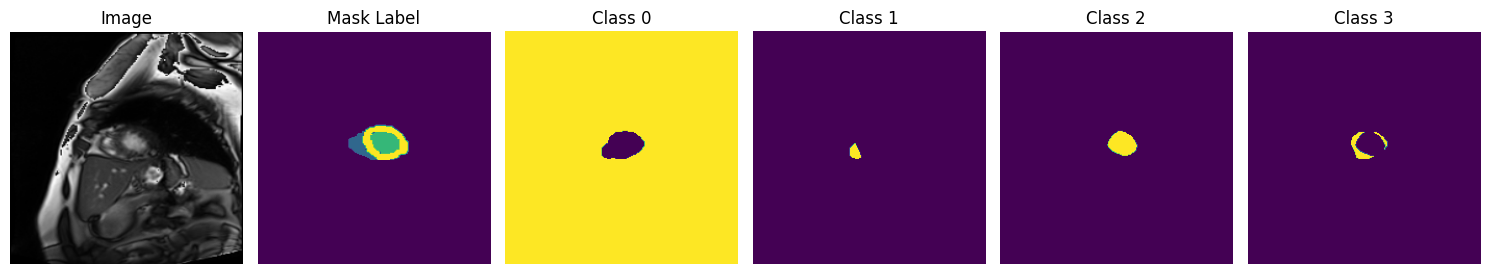

In [18]:
# Plot the first image
plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(images[1, 0, :, :], cmap='gray')
plt.title('Image')
plt.axis('off')

# Plot the first image
plt.subplot(1, 6, 2)
plt.imshow(np.argmax(masks[1, :, :, :], axis=0))
plt.title('Mask Label')
plt.axis('off')

# Plot the class segmentations
for i in range(4):
    plt.subplot(1, 6, i + 3)
    plt.imshow((outputs[1, :, :] == i).astype(np.uint8))  # Assuming class segmentations are one-hot encoded
    plt.title(f'Class {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
for images_train, masks_train, _ in train_loader:
    images, masks = images_train.to(device), masks_train.to(device)

    segmentation_outputs = upernet_model(images)
    break

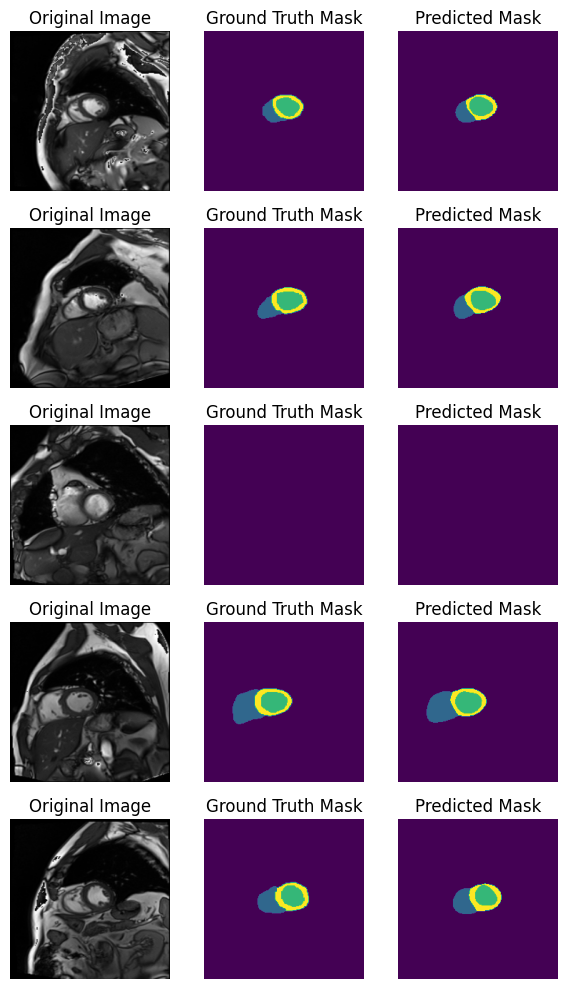

In [21]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Set the figure size and adjust layout
fig = plt.figure(figsize=(6, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

y=0
# Loop through the batch and plot images
for idx in range(5):
    # Plot the original image
    plt.subplot(5, 3, idx * 3 + 1)
    plt.imshow(images[idx + y, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Plot the ground truth mask
    plt.subplot(5, 3, idx * 3 + 2)
    plt.imshow(torch.argmax(masks, dim=1).cpu().numpy()[idx+y,:,:], cmap='viridis')  # Adjust the colormap if needed
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(5, 3, idx * 3 + 3)
    plt.imshow(torch.argmax(segmentation_outputs, dim=1).cpu().numpy()[idx+y,:,:], cmap='viridis')
    plt.title("Predicted Mask")
    plt.axis('off')
    
# Use tight_layout to automatically adjust subplot parameters
plt.tight_layout()

# Show the plot
plt.show()
